In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/attacked-text/attacked_text.csv
/kaggle/input/watermarked-and-unwatermarked-text-truncated/data_trunk.csv


In [2]:
!git clone https://github.com/jthickstun/watermark.git

Cloning into 'watermark'...
remote: Enumerating objects: 80, done.
remote: Counting objects: 100% (80/80), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 80 (delta 25), reused 67 (delta 14), pack-reused 0
Unpacking objects: 100% (80/80), 264.81 KiB | 5.30 MiB/s, done.


In [3]:
import os
os.chdir("/kaggle/working/watermark/demo")

In [4]:
import os, sys, argparse, time

import numpy as np
from transformers import AutoTokenizer
from mersenne import mersenne_rng

import pyximport
pyximport.install(reload_support=True, language_level=sys.version_info[0],
                  setup_args={'include_dirs':np.get_include()})
from levenshtein import levenshtein

def permutation_test(tokens,key,n,k,vocab_size,n_runs=100):
    rng = mersenne_rng(key)
    xi = np.array([rng.rand() for _ in range(n*vocab_size)], dtype=np.float32).reshape(n,vocab_size)
    test_result = detect(tokens,n,k,xi)

    p_val = 0
    for run in range(n_runs):
        xi_alternative = np.random.rand(n, vocab_size).astype(np.float32)
        null_result = detect(tokens,n,k,xi_alternative)

        # assuming lower test values indicate presence of watermark
        p_val += null_result <= test_result

    return (p_val+1.0)/(n_runs+1.0)


def detect(tokens,n,k,xi,gamma=0.0):
    m = len(tokens)
    n = len(xi)

    A = np.empty((m-(k-1),n))
    for i in range(m-(k-1)):
        for j in range(n):
            A[i][j] = levenshtein(tokens[i:i+k],xi[(j+np.arange(k))%n],gamma)

    return np.min(A)


In file included from /opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/ndarraytypes.h:1929,
                 from /opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/arrayobject.h:5,
                 from /root/.pyxbld/temp.linux-x86_64-cpython-310/kaggle/working/watermark/demo/levenshtein.c:1205:
/opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~


In [5]:
from tqdm import tqdm
import pandas as pd

def main():
    # Read data from CSV using pandas
    data = pd.read_csv("/kaggle/input/attacked-text/attacked_text.csv")
    # Combine filtered data
    split_point1 = int(len(data) / 3)
    split_point2 = split_point1 * 2
    split_point3 = 100
    part1 = data.iloc[:35] # First part
    part2 = data.iloc[35:69]  # Second part
    part3 = data.iloc[69:100]  # Third part (might be slightly bigger)
    # Load pre-trained tokenizer (replace with your desired tokenizer)
    tokenizer = AutoTokenizer.from_pretrained("facebook/opt-350m")

    # Progress bar with tqdm
    results = []
    for index, row in tqdm(part3.iterrows(), total=len(part3)):
        text = row["Attacked Text"]  # Assuming "Attacked Text" is the column containing text data
        actual_label = "watermarked" # Assuming "label" is the column containing actual label

        # Tokenize the text
        tokens = tokenizer.encode(text, return_tensors='pt', truncation=True, max_length=2048).numpy()[0]

        t0 = time.time()
        pval = permutation_test(tokens, 42, 256, len(tokens), len(tokenizer))
        label = "watermarked" if pval <= 0.01 else "unwatermarked"
        results.append({"text": text, "p-value": pval, "label": label, "actual_label": actual_label})
        print(f"Row {index+1} - p-value: {pval:.4f}, label: {label} (elapsed time: {time.time()-t0:.2f}s)")

    # Create a pandas DataFrame from the results
    df_results = pd.DataFrame(results)
#     df_results.head(2)
    # Save the DataFrame (optional)
    df_results.to_csv("permutation_test_results_zerowidth.csv", index=False)
if __name__ == '__main__':
    main()

tokenizer_config.json:   0%|          | 0.00/685 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/644 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/441 [00:00<?, ?B/s]

  3%|▎         | 1/31 [10:09<5:04:43, 609.45s/it]

Row 70 - p-value: 0.5446, label: unwatermarked (elapsed time: 609.42s)


  6%|▋         | 2/31 [20:01<4:49:29, 598.96s/it]

Row 71 - p-value: 0.5644, label: unwatermarked (elapsed time: 591.62s)


 10%|▉         | 3/31 [29:04<4:27:46, 573.81s/it]

Row 72 - p-value: 0.0792, label: unwatermarked (elapsed time: 543.87s)


 13%|█▎        | 4/31 [37:20<4:04:24, 543.11s/it]

Row 73 - p-value: 0.0099, label: watermarked (elapsed time: 496.06s)


 16%|█▌        | 5/31 [45:13<3:44:19, 517.67s/it]

Row 74 - p-value: 0.3663, label: unwatermarked (elapsed time: 472.54s)


 19%|█▉        | 6/31 [56:19<3:56:44, 568.17s/it]

Row 75 - p-value: 0.7129, label: unwatermarked (elapsed time: 666.19s)


 23%|██▎       | 7/31 [1:05:34<3:45:32, 563.87s/it]

Row 76 - p-value: 0.0792, label: unwatermarked (elapsed time: 555.03s)


 26%|██▌       | 8/31 [1:14:39<3:33:50, 557.84s/it]

Row 77 - p-value: 0.0099, label: watermarked (elapsed time: 544.93s)


 29%|██▉       | 9/31 [1:24:54<3:31:01, 575.55s/it]

Row 78 - p-value: 0.2079, label: unwatermarked (elapsed time: 614.47s)


 32%|███▏      | 10/31 [1:34:23<3:20:44, 573.55s/it]

Row 79 - p-value: 0.0891, label: unwatermarked (elapsed time: 569.07s)


 35%|███▌      | 11/31 [1:42:16<3:00:59, 542.95s/it]

Row 80 - p-value: 0.4851, label: unwatermarked (elapsed time: 473.57s)


 39%|███▊      | 12/31 [1:50:48<2:48:56, 533.50s/it]

Row 81 - p-value: 0.0198, label: unwatermarked (elapsed time: 511.88s)


 42%|████▏     | 13/31 [1:57:23<2:27:26, 491.48s/it]

Row 82 - p-value: 0.6040, label: unwatermarked (elapsed time: 394.77s)


 45%|████▌     | 14/31 [2:06:20<2:23:07, 505.15s/it]

Row 83 - p-value: 0.2574, label: unwatermarked (elapsed time: 536.73s)


 48%|████▊     | 15/31 [2:16:01<2:20:48, 528.04s/it]

Row 84 - p-value: 0.0495, label: unwatermarked (elapsed time: 581.11s)


 52%|█████▏    | 16/31 [2:25:09<2:13:32, 534.16s/it]

Row 85 - p-value: 0.0099, label: watermarked (elapsed time: 548.35s)


 55%|█████▍    | 17/31 [2:36:23<2:14:28, 576.29s/it]

Row 86 - p-value: 0.1881, label: unwatermarked (elapsed time: 674.28s)


 58%|█████▊    | 18/31 [2:44:39<1:59:37, 552.13s/it]

Row 87 - p-value: 0.4950, label: unwatermarked (elapsed time: 495.88s)


 61%|██████▏   | 19/31 [2:51:45<1:42:50, 514.17s/it]

Row 88 - p-value: 0.0198, label: unwatermarked (elapsed time: 425.75s)


 65%|██████▍   | 20/31 [3:00:13<1:33:55, 512.29s/it]

Row 89 - p-value: 0.0099, label: watermarked (elapsed time: 507.89s)


 68%|██████▊   | 21/31 [3:08:05<1:23:23, 500.31s/it]

Row 90 - p-value: 0.2871, label: unwatermarked (elapsed time: 472.39s)


 71%|███████   | 22/31 [3:18:11<1:19:48, 532.02s/it]

Row 91 - p-value: 0.6238, label: unwatermarked (elapsed time: 605.97s)


 74%|███████▍  | 23/31 [3:28:57<1:15:29, 566.19s/it]

Row 92 - p-value: 0.6436, label: unwatermarked (elapsed time: 645.87s)


 77%|███████▋  | 24/31 [3:37:41<1:04:33, 553.42s/it]

Row 93 - p-value: 0.7327, label: unwatermarked (elapsed time: 523.62s)


 81%|████████  | 25/31 [3:44:43<51:23, 513.93s/it]  

Row 94 - p-value: 0.0099, label: watermarked (elapsed time: 421.81s)


 84%|████████▍ | 26/31 [3:52:57<42:20, 508.03s/it]

Row 95 - p-value: 0.6535, label: unwatermarked (elapsed time: 494.26s)


 87%|████████▋ | 27/31 [4:01:02<33:24, 501.22s/it]

Row 96 - p-value: 0.1584, label: unwatermarked (elapsed time: 485.33s)


 90%|█████████ | 28/31 [4:08:22<24:08, 482.92s/it]

Row 97 - p-value: 0.0198, label: unwatermarked (elapsed time: 440.21s)


 94%|█████████▎| 29/31 [4:18:32<17:22, 521.04s/it]

Row 98 - p-value: 0.2277, label: unwatermarked (elapsed time: 609.98s)


 97%|█████████▋| 30/31 [4:25:42<08:13, 493.46s/it]

Row 99 - p-value: 0.0099, label: watermarked (elapsed time: 429.10s)


100%|██████████| 31/31 [4:37:04<00:00, 536.27s/it]

Row 100 - p-value: 0.3762, label: unwatermarked (elapsed time: 682.44s)


In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


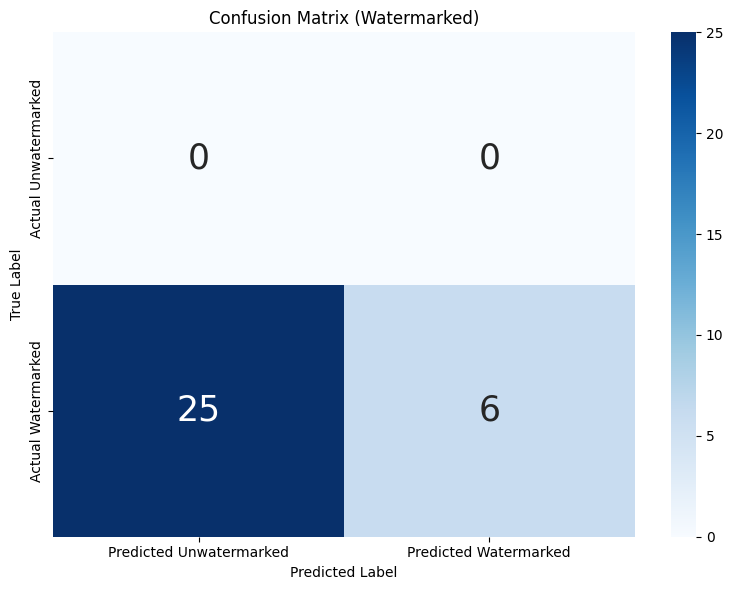


Classification Metrics:
Accuracy: 19.3548
F1-score: 32.4324
Precision: 100.0000
Recall: 19.3548


In [7]:
def evaluate_classification(file_path):

    # Evaluates a classification model using various metrics, reading data from a CSV file and creates a confusion matrix heatmap using seaborn.

    # Read the CSV file assuming 'label' and 'actual_label' columns are present
    df = pd.read_csv(file_path)

    # Extract true labels (assuming 'actual_label' column)
    y_true = df['actual_label'].tolist()

    # Extract predicted labels (assuming 'label' column)
    y_pred = df['label'].tolist()

    # Create the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Calculate accuracy
    accuracy = accuracy_score(y_true, y_pred)

    # Calculate F1-score
    f1 = f1_score(y_true, y_pred, average='weighted')

    # Calculate precision
    precision = precision_score(y_true, y_pred, average='weighted')

    # Calculate recall
    recall = recall_score(y_true, y_pred, average='weighted')
      # Define custom labels for the confusion matrix

    # Create a confusion matrix heatmap using seaborn
    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='d',annot_kws={'fontsize': 25})
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    ax.set_title('Confusion Matrix (Watermarked)')
    plt.xticks([0.5, 1.5], ['Predicted Unwatermarked', 'Predicted Watermarked'])
    plt.yticks([0.5, 1.5], ['Actual Unwatermarked', 'Actual Watermarked'])    
    plt.tight_layout()
    plt.show()
    return cm, accuracy, f1, precision, recall

# Specify the file path (assuming you're using Kaggle)
file_path = "/kaggle/working/watermark/demo/permutation_test_results_zerowidth.csv"

# Evaluate the classification
cm, accuracy, f1, precision, recall = evaluate_classification(file_path)

# Print classification metrics (same as before)
print("\nClassification Metrics:")
print(f"Accuracy: {accuracy * 100:.4f}")
print(f"F1-score: {f1 * 100:.4f}")
print(f"Precision: {precision * 100:.4f}")
print(f"Recall: {recall * 100:.4f}")


In [8]:
def evaluate_misclassifications(file_path):
    # Evaluates the average absolute difference between misclassified p-values and the threshold (0.1) for watermarked images.
    # Read the CSV file into a Pandas DataFrame
    df = pd.read_csv(file_path)

    # Filter for misclassified watermarked images
    misclassified_watermarked = df[(df['label'] != df['actual_label']) & (df['actual_label'] == 'watermarked')]

    # Check if there are any misclassified watermarked images
    if len(misclassified_watermarked) == 0:
        print("No misclassified watermarked images found.")
        return None

    # Calculate absolute difference between misclassified p-values and the threshold (0.1)
    abs_diff = np.abs(misclassified_watermarked['p-value'] - 0.1)

    # Calculate average absolute difference
    average_diff = np.mean(abs_diff)

    return average_diff

# Specify the file path
file_path = "/kaggle/working/watermark/demo/permutation_test_results_zerowidth.csv"

# Evaluate misclassifications
average_diff = evaluate_misclassifications(file_path)

if average_diff is not None:
    print(f"Average absolute difference for misclassified watermarked images: {average_diff:.4f}")


Average absolute difference for misclassified watermarked images: 0.2669


In [9]:
def get_incorrect_samples(file_path):
   
    # Extracts all samples from a CSV file where 'label' and 'actual_label' differ.
    # Read the CSV file into a Pandas DataFrame
    df = pd.read_csv(file_path)

    # Filter for rows where label doesn't equal actual_label
    incorrect_samples = df[df['label'] != df['actual_label']]
    incorrect_samples = incorrect_samples.sort_values(by='actual_label')

    return incorrect_samples

file_path = "/kaggle/working/watermark/demo/permutation_test_results_zerowidth.csv"
incorrect_df = get_incorrect_samples(file_path)


incorrect_df.head(len(incorrect_df))

,text,p-value,label,actual_label
0,We ‌need‍ to create ‍a ​conducive e‍nvi‌ro‌‌nm...,0.544554,unwatermarked,watermarked
27,Th‍e affe‌cted‍‍ leaf ​migh‍t have​ bee‍n ​due...,0.019802,unwatermarked,watermarked
26,F‌armers shou​l​d not ​o‌n‍l‍y‌ th‌in‍k a​bout...,0.158416,unwatermarked,watermarked
25,‍​The minister advised teachers t‌o ​be ‍unite...,0.653465,unwatermarked,watermarked
23,W‌e‌‍ h​ad‍ a bett​er increase in​​ income ‍pe...,0.732673,unwatermarked,watermarked
22,Teenage pre​gnan​cy is a‍ maj​‌or i​nt​erf​e‍‌...,0.643564,unwatermarked,watermarked
21,They hav​e ‍b‍een​ abl​e to c‍on​trol this ‍pa...,0.623762,unwatermarked,watermarked
20,‌Publi‍c ‌‌meetin‌g‍s‍ c‌an ‌lead to‌ the spre...,0.287129,unwatermarked,watermarked
18,Pe‍‍o​‌ple go‌ ‍to bars​ and cinema h‌alls‍ fo...,0.019802,unwatermarked,watermarked
17,Childr​en b​el​‌‌​‌ow ‌t‌he ​‍​ag​e of ‍eighte...,0.495050,unwatermarked,watermarked
